In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
satellite = getSatelliteImage();

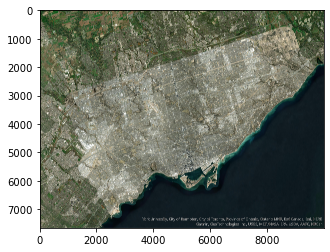

In [7]:
plt.imshow(satellite)

In [5]:
def getSatelliteImage():
    img = cv2.imread("../res/datasets/images/satellite.png", cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    return img;

In [9]:
def getTDCSBSchools():
    return pd.read_csv('../res/datasets/schools/TDCSB_Schools.csv', sep = ',')

tdcsbSchools = getTDCSBSchools()

In [10]:
tdcsbSchools

,_id,OBJECTID,TCDSB_CODE,SCH_NAME,ADDRESS_FULL,MUNICIPALITY,POSTAL_CODE,TCDSB_LEVEL,STATUS,geometry
0,1,1,299,Annunciation,65 Avonwick Gt,North York,M3A 2M8,E,Open,"{'type': 'Point', 'coordinates': (-79.32126781..."
1,2,2,290,All Saints,1435 Royal York Rd,Etobicoke,M9P 3A7,E,Open,"{'type': 'Point', 'coordinates': (-79.52716292..."
2,3,3,222,St. Martin Program,55 Salisbury Ave,former Toronto,M4X 1C5,AL,Open,"{'type': 'Point', 'coordinates': (-79.36442584..."
3,4,4,545,Bishop Marrocco-Thomas Merton,1515 Bloor St W,former Toronto,M6P 1A3,S,Open,"{'type': 'Point', 'coordinates': (-79.45180771..."
4,5,5,549,Bishop Allen Academy,721 Royal York Rd,Etobicoke,M8Y 2T3,S,Open,"{'type': 'Point', 'coordinates': (-79.50446467..."
...,...,...,...,...,...,...,...,...,...,...
205,206,206,239,Our Lady of Perpetual Help,1 1/2 Garfield Ave,former Toronto,M4T 1E6,E,Open,"{'type': 'Point', 'coordinates': (-79.38330488..."
206,207,207,291,St Josaphat,110 Tenth St,Etobicoke,M8V 3G1,E,Open,"{'type': 'Point', 'coordinates': (-79.50905953..."
207,208,208,412,North East SAL Program,100 Fundy Bay Blvd,Scarborough,M1W 3G1,AL,Open,"{'type': 'Point', 'coordinates': (-79.31660336..."
208,209,209,848,East Facilities,97 Railside Rd,North York,M3A 1B2,ADM,Open,"{'type': 'Point', 'coordinates': (-79.32406504..."
